<a href="https://colab.research.google.com/github/Andrea-Cristini/sailgp/blob/main/SailGP_tack_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

WING_CONFIG_unk
11.0    4724
15.0    1304
9.0      263
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6291 entries, 0 to 6290
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              6291 non-null   int64  
 1   BOAT                    6291 non-null   object 
 2   type                    6291 non-null   object 
 3   WING_CONFIG_unk         6291 non-null   float64
 4   DATETIME                6291 non-null   object 
 5   entry_bsp               6291 non-null   float64
 6   exit_bsp                6291 non-null   float64
 7   min_bsp                 6291 non-null   float64
 8   bsp_loss                6291 non-null   float64
 9   entry_twa               6291 non-null   float64
 10  exit_twa                6291 non-null   float64
 11  entry_rh                6288 non-null   float64
 12  exit_rh                 6291 non-null   float64
 13  entry_rh_sta

<Figure size 2000x1500 with 0 Axes>

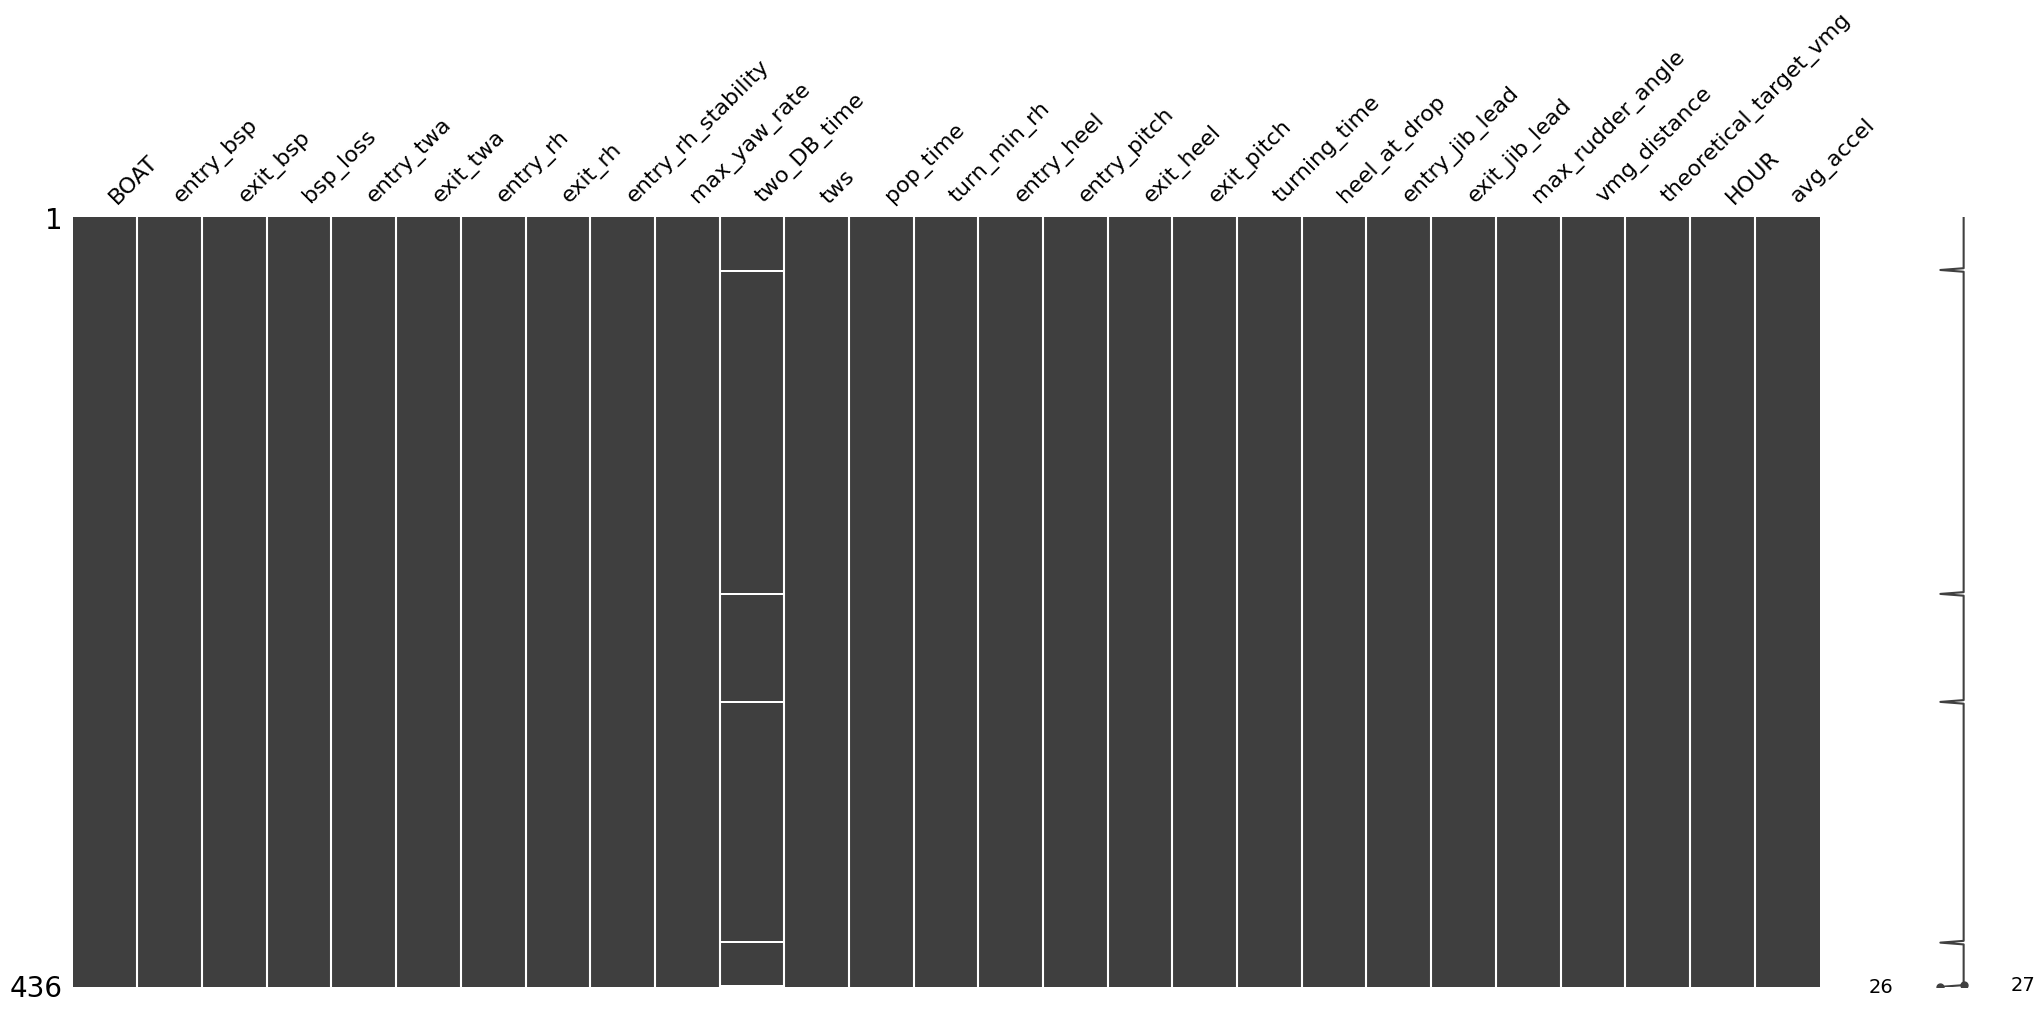

two_DB_time    5.6
dtype: float64
two_DB_time    5.6
dtype: float64
BOAT                      0
entry_bsp                 0
exit_bsp                  0
bsp_loss                  0
entry_twa                 0
exit_twa                  0
entry_rh                  0
exit_rh                   0
entry_rh_stability        0
max_yaw_rate              0
two_DB_time               0
tws                       0
pop_time                  0
turn_min_rh               0
entry_heel                0
entry_pitch               0
exit_heel                 0
exit_pitch                0
turning_time              0
heel_at_drop              0
entry_jib_lead            0
exit_jib_lead             0
max_rudder_angle          0
vmg_distance              0
theoretical_target_vmg    0
HOUR                      0
avg_accel                 0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 436 entries, 2882 to 3317
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  -

<ipython-input-22-1a4f359b7911>:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = col_cat.codes


Random Forest Regression:
-------------------------
Train MAE: 0.21293992491607544
Test MAE: 229.71008792791352

Train MAD: 0.12048246244555492
Test MAD: 44.2132287616364

Train SE: 0.014429483234271744
Test SE: 10.446133389206945

XGBoost:
-------------------------
Train MAE: 0.00047467906728137815
Test MAE: 229.42732045990348

Train MAD: 0.0003432770041806865
Test MAD: 44.57934487539927

Train SE: 3.615576128482028e-05
Test SE: 10.449886373423324


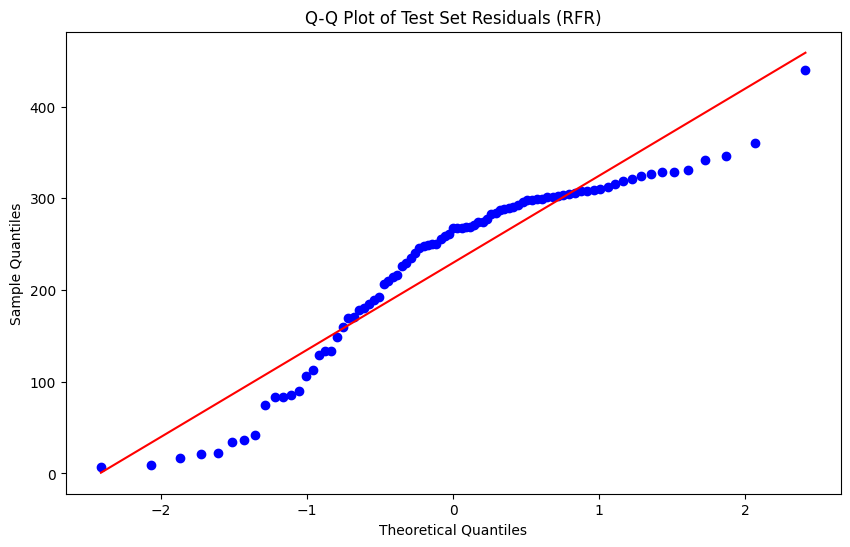

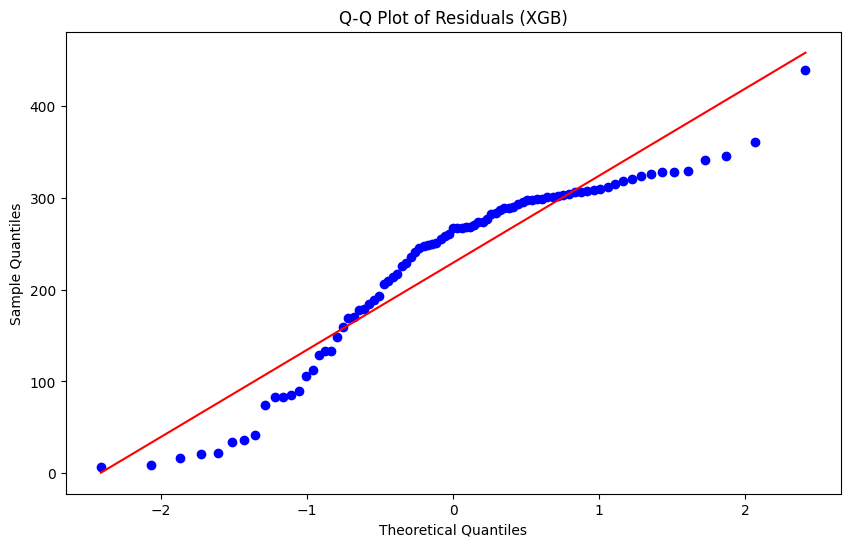

SystemExit: 

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [22]:
""" SailGP tack analysis project.
    -----------------------------
    Notebook which imports the dataset, performs
    some EDA, generates some features, builds some
    candidate models, evaluates model accuracy etc
    and interprets the model results """

# 1. Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import xgboost as xgb
import sys
from scipy.stats import zscore, probplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix

mrow = 100
t_tack = 7.5 # tack time to min bsp in seconds i.e. time between entry bsp and min bsp
config = 9.0 # wing config for potting (must be a float)
eda_flag = False
pd.options.display.min_rows = 0
pd.options.display.max_rows = mrow
pd.options.display.max_columns = mrow

# 2. Load the Dataset
df = pd.read_csv('tack_analysis.csv')

print(df['WING_CONFIG_unk'].value_counts())

# 3. Exploratory Data Analysis (EDA)

# 3.1 Basic Information
print(df.info())
print(df.describe())

df['DATE'] = pd.to_datetime(df['DATETIME'], format='mixed').dt.date
df['HOUR'] = pd.to_datetime(df['DATETIME'], format='mixed').dt.hour
# NOTE: looks like DATETIME might be a universal time and not local time,
#       so splitting out the hours may be of little use

for cat in ('BOAT','type','DATE'):
  print(df[cat].value_counts())

print(df['DATE'])
print(df['HOUR'])

sample_date = pd.to_datetime('2023-06-16').date()

if eda_flag:
  df_samp = df[df['DATE']==sample_date]
  print(df_samp['BOAT'].value_counts())
  print(df_samp['vmg_distance'].nsmallest(10))

  #df_red = df[['BOAT','vmg_distance']]
  # 3.2 Target Variable Distribution
  fig = plt.figure(figsize=(13.,10.))
  sns.violinplot(x='BOAT', y='vmg_distance',data=df_samp, cut=0)
  plt.title('vmg_distance distribution by team for 16-06-23')
  plt.show()

  # distributions are non-normal - need to account for outliers
  print("violin")

  # 3.3 Target-feature relationships
  def target_feat(df, target):
      numeric_columns = df.select_dtypes(include=['float64', 'int32']).columns
      for column in numeric_columns:
          if column != target:
              fig = px.scatter(df, x=column, y=target, title=f'{target} vs {column}')
              fig.show()

  target_feat(df_samp, 'vmg_distance')

  # 3.4 Feature Distributions
  print(df_samp.columns)
  df_samp_num = df_samp.drop(columns=(['Unnamed: 0','BOAT','type',
    'WING_CONFIG_unk','DATETIME','DATE','t_invert']))
  df_samp_num.hist(bins=50, figsize=(20, 15))
  plt.show()

  # 3.5 Correlation Matrix
  fig = plt.figure(figsize=(20.,15.))
  corr_matrix = df_samp_num.corr()
  sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
  plt.title('Correlation Matrix')
  plt.show()

# 4.1 Feature Engineering
# feature ideas:
# 1) deceleration = (bsp_loss)/(15/3600)
#   if turning_time = time between entry and exit then use
#   half of this instead for the time
# 2) time between tacks = datetime[n+1] - (datetime[n] + turning_time)

decel = df['bsp_loss']/(t_tack*3600)
accel = (df['exit_bsp'] - df['min_bsp'])/(t_tack*3600)
df['avg_accel'] = (decel + accel)/2
print(df['avg_accel'])

#NOTE: exit boatspeed and min boatspeed are highly correlated,
#      also the boatspeed at drop is highly correlated with the
#      entry boatspeed. At least one of these four variables could
#      be removed, suggest removal of min boatspeed as
#      loss = entry - min, and loss is a relative measure. Also
#      suggest removal of bsp_at_drop in place of entry_bsp.

#NOTE: entry_jib_lead/entry_jib_sheet and exit_jib_lead/exit_jib_sheet
#      are highly correlated. As the data quality of the jib_sheet
#      variables are poor, suggest removal of these variables in place
#      of their lead analogues

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#          POTTING
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# pot by config
#df = df[df['WING_CONFIG_unk']==config] ###AJC

# pot by date
df = df[df['DATE']==sample_date]


print(df)

df_clean = df.drop(columns=(['Unnamed: 0','type','DATETIME','t_invert', 'WING_CONFIG_unk',### AJC config needed for potting by config/date
            'bsp_at_drop','min_bsp','entry_jib_sheet','exit_jib_sheet','DATE'])) # AJC remove date if not potting by date
print(df_clean.columns)

# 4.2 Handling Missing Values
# Fill missing values or drop missing data
#df['column'] = df['column'].fillna(df['column'].mean())

missing_values = df_clean.isnull()
#df_imp = df_clean[missing_values==True]
#print(df_imp.columns)
#print(df_clean[missing_values.any(axis=1)])
print(missing_values.sum())
cols_miss = df_clean.columns[missing_values.sum() > 0]
print(cols_miss)

fig = plt.figure(figsize=(20, 15))
#sns.heatmap(missing_values.corr(), annot=True, cmap='coolwarm')
msno.matrix(df_clean)
plt.show()

#TODO: impute missing values with their median values as all
#      distributions with missing values are non-normal

meds = df_clean[cols_miss].median()
print(meds)

df_clean[cols_miss] = df_clean[cols_miss].fillna(meds)

meds = df_clean[cols_miss].median()
print(meds)

missing_values = df_clean.isnull()
print(missing_values.sum())

print(df_clean.info())

# 4.3 Outlier detection
# Basic outlier detection in place, calibrated using the sample subset
# for all tacks on 16-06-23 ---> z-scores > 7 std devs are considered outliers.
# NOTE: This method is slightly flawed though as strictly the distributions
# will be independent to each unique date as the conditions will change with
# location, time of year etc. Identifying outliers based on the full
# distribution may result in removing inliers when the conditions are extreme.

numeric_columns = df_clean.select_dtypes(include=['float64', 'int32']).columns

# Calculate Z-scores for each numeric column
z_scores = df_clean[numeric_columns].apply(zscore)

# Identify outliers which are more than 7 std devs from the mean
outliers = (np.abs(z_scores) >= 7)

# Print the outliers for each column
for column in numeric_columns:
    outlier_rows = df_clean[outliers[column]]
    print(f'Outliers in {column}:')
    print(outlier_rows[column])

# Remove outliers
df_clean = df_clean[(np.abs(z_scores) < 7).all(axis=1)]

# 4.4 Encoding Categorical Variables
# encode categories and dates (HOUR does not need encoding as it is ordinal)
#df_clean['WING_CONFIG_unk'] = df_clean['WING_CONFIG_unk'].astype('object') ### AJC comment out for potting
cat_feats = df_clean.select_dtypes(include=['object']).columns
for col in cat_feats:
    col_cat = df_clean[col].astype('category').cat
    df_clean[col] = col_cat.codes
    print('\n'+col+' encodings = ',dict(enumerate(col_cat.categories)))

#print(enumerate(df_clean.cat.categories))

#print(df_clean)


# 5. Model Building

# 5.0 Train-test split
X = df_clean.drop('vmg_distance', axis=1)
y = df_clean['vmg_distance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5.1 Feature Scaling
# I prefer RobustScalar as it standardises using the median, whereas
#  other scalars use the mean or min/max which are susceptible to outliers

# NOTE: important to standardise after splitting train and test sets,
#  else the test set distribution will leak into the training data
scaler = RobustScaler()

Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_feats = Xy_train.select_dtypes(include=['int32', 'float64']).columns
Xy_train[Xy_feats] = scaler.fit_transform(Xy_train[Xy_feats])
X_train = Xy_train.drop('vmg_distance', axis=1)
y_train = Xy_train['vmg_distance']
print(X_train)
print(y_train)

# 5.2 Define the Model
model_rfr = RandomForestRegressor(n_estimators=100, random_state=42)
model_xgb = xgb.XGBRegressor(n_estimators=100, random_state=42)

# 5.3 Train the Model
model_rfr.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)

# 6. Model Evaluation

# 6.1 Train and test set predictions
preds_train_rfr = model_rfr.predict(X_train)
preds_train_xgb = model_xgb.predict(X_train)

preds_test_rfr = model_rfr.predict(X_test)
preds_test_xgb = model_xgb.predict(X_test)

# 6.2 Performance metrics
# MAE, MAD and 4*SE
# also do a q-q-plot of the residuals to check if they are normal
# then 4*SE will account for 95% of the residuals

# Calculate residuals
train_res_rfr = y_train - preds_train_rfr
train_res_xgb = y_train - preds_train_xgb

test_res_rfr = y_test - preds_test_rfr
test_res_xgb = y_test - preds_test_xgb

# Calculate MAE
train_mae_rfr = np.mean(np.abs(train_res_rfr))
train_mae_xgb = np.mean(np.abs(train_res_xgb))

test_mae_rfr = np.mean(np.abs(test_res_rfr))
test_mae_xgb = np.mean(np.abs(test_res_xgb))

# Calculate MAD
train_mad_rfr = np.median(np.abs(train_res_rfr - np.median(train_res_rfr)))
train_mad_xgb = np.median(np.abs(train_res_xgb - np.median(train_res_xgb)))

test_mad_rfr = np.median(np.abs(test_res_rfr - np.median(test_res_rfr)))
test_mad_xgb = np.median(np.abs(test_res_xgb - np.median(test_res_xgb)))

# Calculate SE
train_se_rfr = np.std(train_res_rfr) / np.sqrt(len(train_res_rfr))
train_se_xgb = np.std(train_res_xgb) / np.sqrt(len(train_res_xgb))

test_se_rfr = np.std(test_res_rfr) / np.sqrt(len(test_res_rfr))
test_se_xgb = np.std(test_res_xgb) / np.sqrt(len(test_res_xgb))

# Display Metrics
print("Random Forest Regression:")
print("-------------------------")
print(f"Train MAE: {train_mae_rfr}")
print(f"Test MAE: {test_mae_rfr}")

print(f"\nTrain MAD: {train_mad_rfr}")
print(f"Test MAD: {test_mad_rfr}")

print(f"\nTrain SE: {train_se_rfr}")
print(f"Test SE: {test_se_rfr}")


print("\nXGBoost:")
print("-------------------------")
print(f"Train MAE: {train_mae_xgb}")
print(f"Test MAE: {test_mae_xgb}")

print(f"\nTrain MAD: {train_mad_xgb}")
print(f"Test MAD: {test_mad_xgb}")

print(f"\nTrain SE: {train_se_xgb}")
print(f"Test SE: {test_se_xgb}")

# Q-Q plot for residuals against normal distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
probplot(test_res_rfr, dist="norm", plot=axes[0])
plt.title('Q-Q Plot of Test Set Residuals (RFR)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

plt.figure(figsize=(10, 6))
probplot(test_res_xgb, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (XGB)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

# --- 1st attempt ---
# Initial results show that the model is massively overfitting for both models
# This is likely due to the dataset having multiple distributions due to
# different conditions, time of year, boat setup etc.
# Next step would be to apply some "potting" to the data.
# Train MAD ~ 0.04, Test MAD = 64

# --- 2nd attempt ---
# pot the data by configuration, doesn't seem to make a difference.
# For config = 11.0, test MAD = 64
# For config = 9.0, train MAD = 0.1/2e-4, test MAD = 39

# --- 3rd attempt ---
# try a single date - 16/06/23
# train MAD = 0.12/3e-4, test MAD = 44

sys.exit()


# 7. Model Interpretation

# 7.1 Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()

# 7.2 SHAP Values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 7.3 SHAP Summary Plot
shap.summary_plot(shap_values, X_test)

# 7.4 SHAP Dependence Plot
shap.dependence_plot('feature_name', shap_values[1], X_test)

# 8. Conclusion and Next Steps
# Summarize findings, potential improvements, and next steps for further analysis
